In [16]:
!pip install pandas numpy msgpack matplotlib

12029.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import os
import json


recording_location = "/Users/nirbhaysinghnarang/recordings/2024_09_18/001"
pupil_data = os.path.join(recording_location, 'pupil.pldata')
metadata_path = os.path.join(recording_location, "info.player.json")

with open(metadata_path, 'r') as file:
    metadata = json.load(file)

SYSTEM_START_TIME = metadata["start_time_system_s"]
PUPIL_LABS_START_TIME = metadata["start_time_synced_s"]
OFFSET = SYSTEM_START_TIME - PUPIL_LABS_START_TIME

In [5]:

import collections
import logging
import os
import pickle
import shutil
import traceback as tb
from glob import iglob
import msgpack
import numpy as np

class _Empty(object):
    def purge_cache(self):
        pass

logger = logging.getLogger(__name__)
UnpicklingError = pickle.UnpicklingError

PLData = collections.namedtuple('PLData', ['data', 'timestamps', 'topics'])

class _FrozenDict(dict):
    def __setitem__(self, key, value):
        raise NotImplementedError('Invalid operation')

    def clear(self):
        raise NotImplementedError()

    def update(self, *args, **kwargs):
        raise NotImplementedError()

class Serialized_Dict(object):
    __slots__ = ['_ser_data', '_data']
    cache_len = 100
    _cache_ref = [_Empty()] * cache_len
    MSGPACK_EXT_CODE = 13

    def __init__(self, python_dict=None, msgpack_bytes=None):
        if type(python_dict) is dict:
            self._ser_data = msgpack.packb(python_dict, use_bin_type=True,
                                           default=self.packing_hook)
        elif type(msgpack_bytes) is bytes:
            self._ser_data = msgpack_bytes
        else:
            raise ValueError("Neither mapping nor payload is supplied or wrong format.")
        self._data = None

    def _deser(self):
        if not self._data:
            self._data = msgpack.unpackb(self._ser_data, raw=False, use_list=False,
                                         object_hook=self.unpacking_object_hook,
                                         ext_hook=self.unpacking_ext_hook)
            self._cache_ref.pop(0).purge_cache()
            self._cache_ref.append(self)

    @classmethod
    def unpacking_object_hook(self,obj):
        if type(obj) is dict:
            return _FrozenDict(obj)

    @classmethod
    def packing_hook(self, obj):
        if isinstance(obj, self):
            return msgpack.ExtType(self.MSGPACK_EXT_CODE, obj.serialized)
        raise TypeError("can't serialize {}({})".format(type(obj), repr(obj)))

    @classmethod
    def unpacking_ext_hook(self, code, data):
        if code == self.MSGPACK_EXT_CODE:
            return self(msgpack_bytes=data)
        return msgpack.ExtType(code, data)

    def purge_cache(self):
        self._data = None

    @property
    def serialized(self):
        return self._ser_data

    def __setitem__(self, key, item):
        raise NotImplementedError()

    def __getitem__(self, key):
        self._deser()
        return self._data[key]

    def __repr__(self):
        self._deser()
        return 'Serialized_Dict({})'.format(repr(self._data))

    @property
    def len(self):
        '''Replacement implementation for __len__

        If __len__ is defined numpy will recognize this as nested structure and
        start deserializing everything instead of using this object as it is.
        '''
        self._deser()
        return len(self._data)

    def __delitem__(self, key):
        raise NotImplementedError()

    def get(self,key,default):
        try:
            return self[key]
        except KeyError:
            return default

    def clear(self):
        raise NotImplementedError()

    def copy(self):
        self._deser()
        return self._data.copy()

    def has_key(self, k):
        self._deser()
        return k in self._data

    def update(self, *args, **kwargs):
        raise NotImplementedError()

    def keys(self):
        self._deser()
        return self._data.keys()

    def values(self):
        self._deser()
        return self._data.values()

    def items(self):
        self._deser()
        return self._data.items()

    def pop(self, *args):
        raise NotImplementedError()

    def __cmp__(self, dict_):
        self._deser()
        return self._data.__cmp__(dict_)

    def __contains__(self, item):
        self._deser()
        return item in self._data

    def __iter__(self):
        self._deser()
        return iter(self._data)

In [3]:

import collections
import msgpack
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def load_pldata(file_path):

    topics = collections.deque()
    with open(file_path, "rb") as f:
        unpacker = msgpack.Unpacker(f, raw=False, use_list=False)
        for topic, payload in unpacker:
            unpacked = Serialized_Dict(msgpack_bytes=payload)
            topics.append(unpacked)
            
            
    return topics


    
topics = load_pldata(pupil_data)





  Difficulty  Start Time (Unix)  End Time (Unix)  Duration (seconds)
0       Easy       1.726702e+09     1.726702e+09               47.84
1       Hard       1.726702e+09     1.726702e+09               57.10
2       Hard       1.726702e+09     1.726702e+09               50.70
3       Easy       1.726702e+09     1.726702e+09               47.26
4       Easy       1.726702e+09     1.726702e+09               50.51


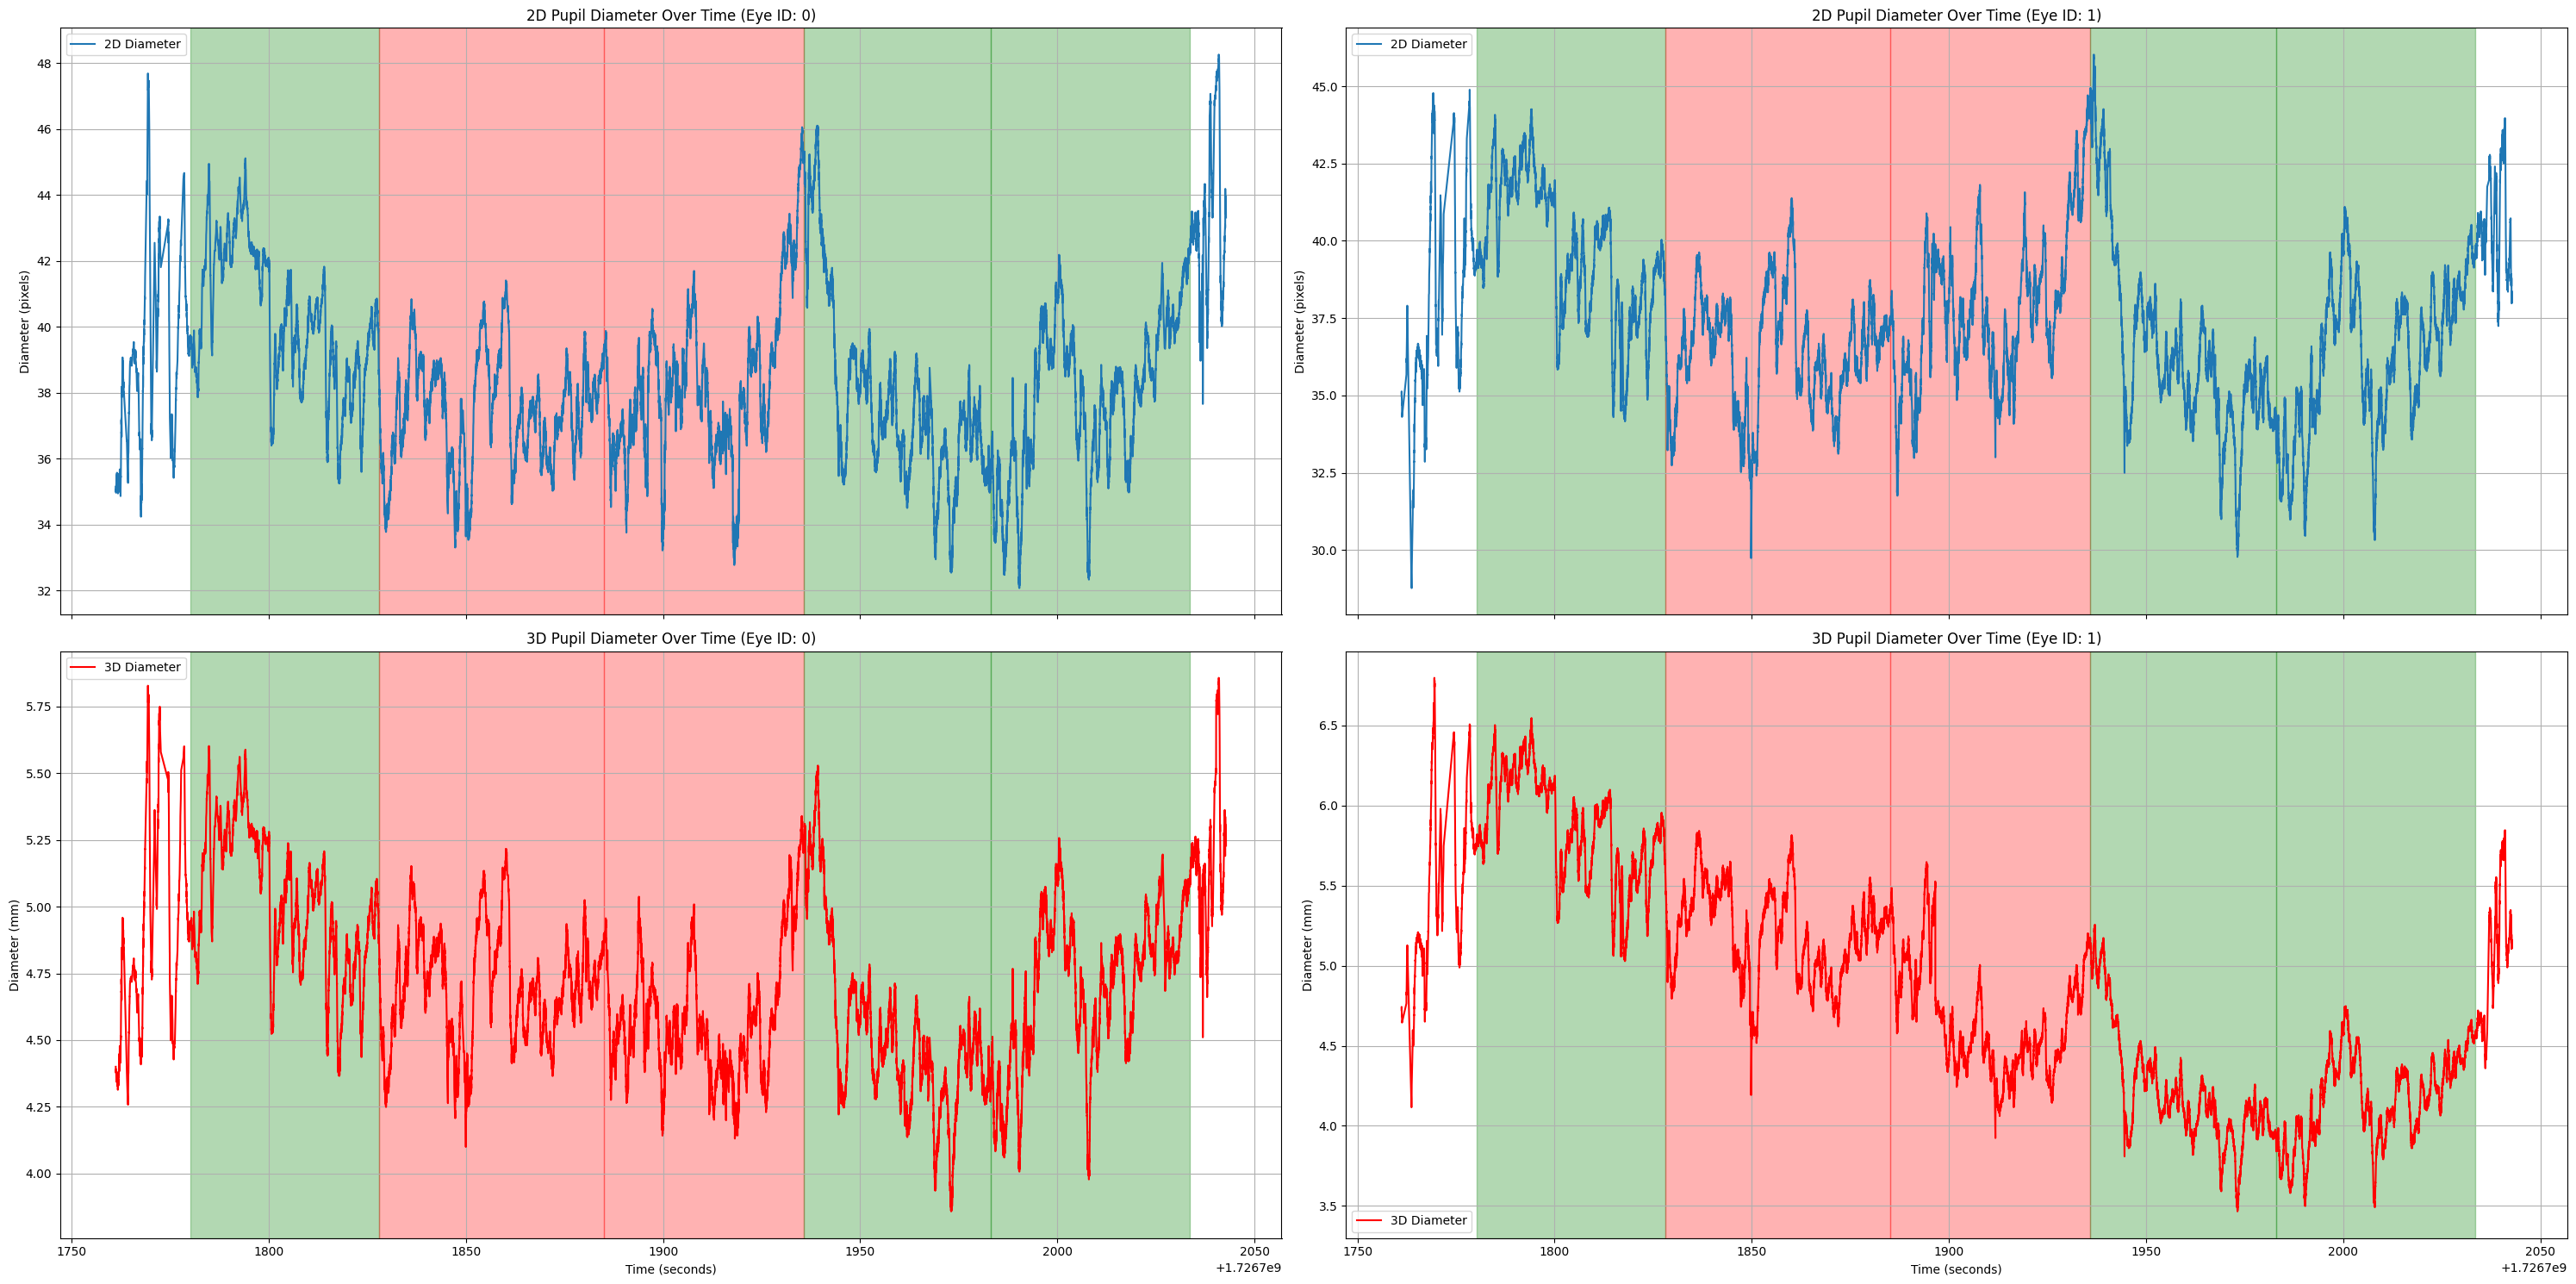

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def filter_valid_data(pupil_data_list, confidence_threshold=1):
    return [
        data for data in pupil_data_list 
        if data['confidence'] >= confidence_threshold and 'diameter_3d' in data
    ]

def segment_by_id(pupil_data_list):
    segmented_data = defaultdict(list)
    for data in pupil_data_list:
        segmented_data[data['id']].append(data)
    return dict(segmented_data)

def extract_diameters(pupil_data_list):
    timestamps = []
    diameters_2d = []
    diameters_3d = []
    confidences = []
    
    for data in pupil_data_list:
        timestamps.append(data['timestamp'])
        diameters_2d.append(data['diameter'])
        diameters_3d.append(data['diameter_3d'])
        confidences.append(data['confidence'])
    
    return np.array(timestamps), np.array(diameters_2d), np.array(diameters_3d), np.array(confidences)

def plot_pupil_diameters(pupil_data_list, difficulty_csv_path):
    filtered_data = filter_valid_data(pupil_data_list)
    segmented_data = segment_by_id(filtered_data)
    if not segmented_data:
        print("No valid data points found after filtering.")
        return

    # Load difficulty data
    difficulty_df = pd.read_csv(difficulty_csv_path)
    print(difficulty_df)


    fig, axes = plt.subplots(2, len(segmented_data), figsize=(15*len(segmented_data), 15), sharex='col', squeeze=False)
    
    for idx, (eye_id, eye_data) in enumerate(segmented_data.items()):
        timestamps, diameters_2d, diameters_3d, confidences = extract_diameters(eye_data)
        timestamps = timestamps + OFFSET

        # Plot 2D diameter
        axes[0, idx].plot(timestamps, diameters_2d, label='2D Diameter')
        axes[0, idx].set_ylabel('Diameter (pixels)')
        axes[0, idx].set_title(f'2D Pupil Diameter Over Time (Eye ID: {eye_id})')
        axes[0, idx].legend()
        axes[0, idx].grid(True)

        # Plot 3D diameter
        axes[1, idx].plot(timestamps, diameters_3d, label='3D Diameter', color='red')
        axes[1, idx].set_ylabel('Diameter (mm)')
        axes[1, idx].set_title(f'3D Pupil Diameter Over Time (Eye ID: {eye_id})')
        axes[1, idx].legend()
        axes[1, idx].grid(True)

        # Add difficulty bars
        for _, row in difficulty_df.iterrows():
            start = row['Start Time (Unix)']
            end = row['End Time (Unix)']
            color = 'green' if row['Difficulty'] == 'Easy' else 'red'
            
            axes[0, idx].axvspan(start, end, alpha=0.3, color=color)
            axes[1, idx].axvspan(start, end, alpha=0.3, color=color)

        # Set x-axis label
        axes[1, idx].set_xlabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

plot_pupil_diameters(topics, "./hsk1-3-caydenr1.csv")

TypeError: SpanSelector.__init__() got an unexpected keyword argument 'rectprops'

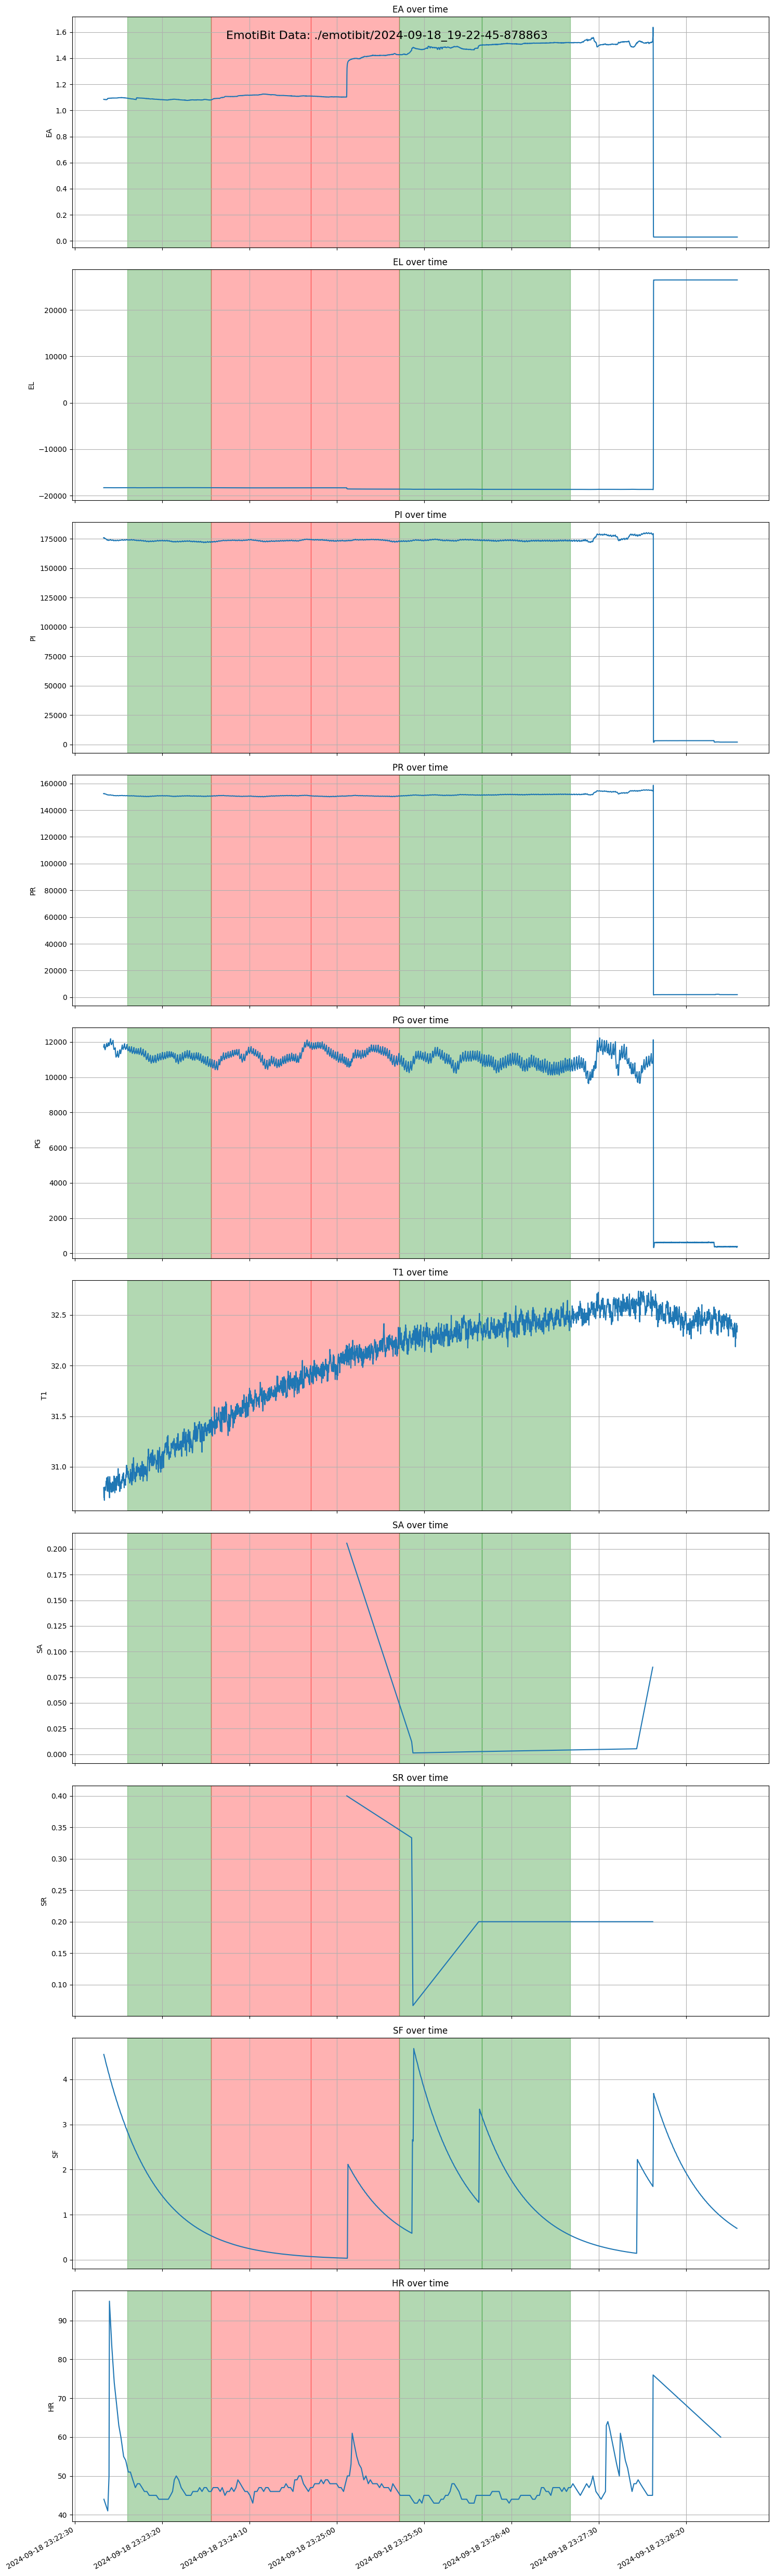

In [33]:
import csv
import pandas as pd

import pandas as pd

file_slug = "./emotibit/2024-09-18_19-22-45-878863"
data_pts = ["EA", "EL", "PI", "PR", "PG", "T1", "SA", "SR", "SF", "HR"]
dfs = []

for pt in data_pts:
    df = pd.read_csv(f"{file_slug}_{pt}.csv")
    dfs.append({'type': pt, 'df': df})

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_emotibit_data(dfs, file_slug, difficulty_csv_path):
    difficulty_df = pd.read_csv(difficulty_csv_path)

    n_plots = len(dfs)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 5 * n_plots), sharex=True)
    fig.suptitle(f"EmotiBit Data: {file_slug}", fontsize=16)

    for i, data in enumerate(dfs):
        df = data['df']
        data_type = data['type']
        

        # Plot the data
        axes[i].plot(df['LocalTimestamp'], df[data_type])
        axes[i].set_ylabel(data_type)
        axes[i].set_title(f"{data_type} over time")
        axes[i].grid(True)

        # Add difficulty overlay
        for _, row in difficulty_df.iterrows():
            start = row['Start Time (Unix)']
            end = row['End Time (Unix)']
            color = 'green' if row['Difficulty'] == 'Easy' else 'red'
            axes[i].axvspan(start, end, alpha=0.3, color=color)


 

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Use tight layout to prevent overlapping
    plt.tight_layout()
    plt.show()
    

plot_emotibit_data(dfs, file_slug, difficulty_csv_path="./paragraph_timestamps.csv")

    
    
    
    
    